In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['imdb-raw', 'glove-global-vectors-for-word-representation']


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional
import matplotlib.pyplot as plt
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
imdb_dir = '../input/imdb-raw/aclimdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [4]:
maxlen = 300 # Cuts off reviews after 100 words
training_samples = 5000 # Trains on 200 samples
validation_samples = 10000 # Validates on 10,000 samples
max_words = 10000 # Considers only the top 10,000 words in the dataset

In [5]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [6]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 72633 unique tokens.


In [7]:
data = pad_sequences(sequences, maxlen=maxlen)

In [8]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (17243, 300)
Shape of label tensor: (17243,)


### Splits the data into a training set and a validation set, but first shuffles the data, because you’re starting with data in which samples are ordered (all negative first, then all positive) 

In [9]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [10]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

### Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors).

In [11]:
glove_dir = '../input/glove-global-vectors-for-word-representation/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector #Words not found in the embedding index will be all zeros. 

In [13]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,960,065
Trainable params: 1,960,065
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [15]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 2s 352us/step - loss: 0.8292 - acc: 0.7162 - val_loss: 0.5911 - val_acc: 0.7254
Epoch 2/10
5000/5000 [==============================] - 1s 259us/step - loss: 0.5208 - acc: 0.7238 - val_loss: 0.5320 - val_acc: 0.7255
Epoch 3/10
5000/5000 [==============================] - 1s 261us/step - loss: 0.4254 - acc: 0.8082 - val_loss: 0.6422 - val_acc: 0.7311
Epoch 4/10
5000/5000 [==============================] - 1s 262us/step - loss: 0.3079 - acc: 0.8778 - val_loss: 0.5428 - val_acc: 0.7623
Epoch 5/10
5000/5000 [==============================] - 1s 262us/step - loss: 0.2066 - acc: 0.9322 - val_loss: 0.5689 - val_acc: 0.7338
Epoch 6/10
5000/5000 [==============================] - 1s 266us/step - loss: 0.1502 - acc: 0.9548 - val_loss: 0.8526 - val_acc: 0.7520
Epoch 7/10
5000/5000 [==============================] - 1s 261us/step - loss: 0.1043 - acc: 0.9738 - val_loss: 0.6384 - val_acc: 0.7458

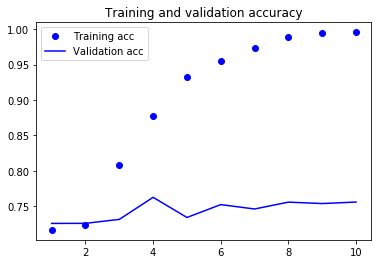

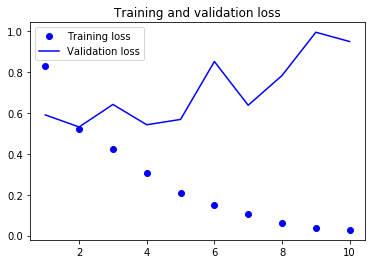

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Questão 2

In [17]:
model1 = Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model1.add(LSTM(dropout=0.3, units=1))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1)                 408       
Total params: 1,000,408
Trainable params: 1,000,408
Non-trainable params: 0
_________________________________________________________________


In [20]:
model1.layers[0].set_weights([embedding_matrix])
model1.layers[0].trainable = False

In [21]:
model1.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model1.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 178s 36ms/step - loss: 0.7367 - acc: 0.6502 - val_loss: 0.6247 - val_acc: 0.6851
Epoch 2/10
5000/5000 [==============================] - 177s 35ms/step - loss: 0.6435 - acc: 0.6952 - val_loss: 0.6055 - val_acc: 0.7066
Epoch 3/10
5000/5000 [==============================] - 177s 35ms/step - loss: 0.6309 - acc: 0.6994 - val_loss: 0.5969 - val_acc: 0.7149
Epoch 4/10
5000/5000 [==============================] - 175s 35ms/step - loss: 0.6266 - acc: 0.7088 - val_loss: 0.5897 - val_acc: 0.7204
Epoch 5/10
5000/5000 [==============================] - 177s 35ms/step - loss: 0.6062 - acc: 0.7174 - val_loss: 0.5808 - val_acc: 0.7203
Epoch 6/10
5000/5000 [==============================] - 190s 38ms/step - loss: 0.5879 - acc: 0.7198 - val_loss: 0.5744 - val_acc: 0.7219
Epoch 7/10
5000/5000 [==============================] - 199s 40ms/step - loss: 0.5891 - acc: 0.7220 - val_loss: 0.5702 - val_acc:

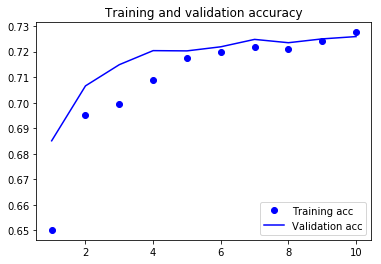

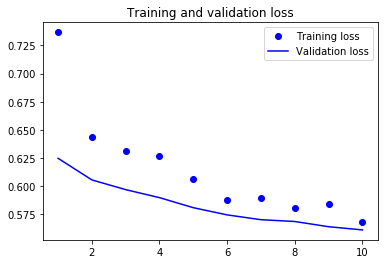

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()